In [15]:
from pytorch3d.ops.knn import knn_points

from skimage import color

def chamfer_distance_rgb(
    x,
    y,
    colors_x = None,
    colors_y = None
):

    """
    Chamfer distance between two pointclouds x and y.

    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    !! Only support batch of size 1 !!
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    Args:
        x: FloatTensor of shape (N, P1, D) or a Pointclouds object representing
            a batch of point clouds with at most P1 points in each batch element,
            batch size N and feature dimension D.
        y: FloatTensor of shape (N, P2, D) or a Pointclouds object representing
            a batch of point clouds with at most P2 points in each batch element,
            batch size N and feature dimension D.
        point_reduction: Reduction operation to apply for the loss across the
            points, can be one of ["mean", "sum"].

    Returns:
        - **loss**: Tensor giving the reduced distance between the pointclouds
          in x and the pointclouds in y.
    """

    # checkt point inputs size
    if x.ndim == 3 and y.ndim == 3 and x.shape[0] == 1 and y.shape[0] == 1:
        pass
    elif x.ndim == 2 and y.ndim == 2:
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)
    else:
        raise ValueError("Expected points to be of shape (1, P, D) or (P,D)")
    

    if colors_x is not None and colors_y is not None:
        return_cham_colors = True
    else:
        return_cham_colors = False
    
    # get dimension
    N, P1, D = x.shape
    P2 = y.shape[1]

    if y.shape[2] != D:
        raise ValueError("y does not have the correct shape.")


    # checkt colors inputs size
    if return_cham_colors:
        if colors_x.ndim == 3 and colors_y.ndim == 3 and colors_x.shape[0] == 1 and colors_y.shape[0] == 1:
            colors_x = colors_x.squeeze()
            colors_y = colors_y.squeeze()
        elif colors_x.ndim == 2 and colors_y.ndim == 2:
            pass
        else:
            raise ValueError("Expected colors of points to be of shape (1, P, D) or (P,D)")

        if colors_x.shape[0] != P1 or colors_y.shape[0] != P2:
            raise ValueError("colors inputs size must match points size.")

        if colors_x.shape[1] != 3 or colors_y.shape[1] != 3:
            raise ValueError("last dimension or colors input should be of size 3 as it should be rgb values")

        if colors_x.max() > 1.0 or colors_x.min() < 0.0 or colors_y.max() > 1.0 or colors_y.min() < 0.0:
            raise ValueError("Colors values must be normalized between 0 and 1")
            


    # find nearest neighbours
    x_nn = knn_points(x, y, K=1)
    y_nn = knn_points(y, x, K=1)

    # get distance error from knn
    cham_x = x_nn.dists[..., 0]
    cham_y = y_nn.dists[..., 0]

    cham_x = cham_x.squeeze().sum()
    cham_y = cham_y.squeeze().sum()

    # average through all points
    cham_x = cham_x/P1
    cham_y = cham_y/P2

    cham_dist = cham_x + cham_y


    if return_cham_colors:

        # get lab colors too
        colors_x_lab = torch.tensor(color.rgb2lab(colors_x.cpu().numpy())).cuda()
        colors_y_lab = torch.tensor(color.rgb2lab(colors_y.cpu().numpy())).cuda()
        
        # find index from knn results
        idx_x = x_nn.idx[..., 0].squeeze()
        idx_y = y_nn.idx[..., 0].squeeze()

        # compute rgb error
        error_x_rgb = torch.nn.L1Loss()(colors_x[:], colors_y[idx_x])
        error_y_rgb = torch.nn.L1Loss()(colors_y[:], colors_x[idx_y])

        # normalize
        cham_colors_rgb = (error_x_rgb + error_y_rgb) / 2
        cham_colors_rgb = cham_colors_rgb * 255

        # compute lab error
        error_x_lab = torch.nn.L1Loss()(colors_x_lab[:], colors_y_lab[idx_x])
        error_y_lab = torch.nn.L1Loss()(colors_y_lab[:], colors_x_lab[idx_y])

        cham_colors_lab = (error_x_lab + error_y_lab) / 2
        
    else:
        cham_colors_rgb = None
        cham_colors_lab = None

    return cham_dist, cham_colors_rgb, cham_colors_lab



In [16]:
chamfer_distance_rgb(verts_1, verts_2, colors_x = colors_1, colors_y = colors_2)

(tensor(1.3923),
 tensor(78.6157, device='cuda:0'),
 tensor(11.7079, device='cuda:0'))

In [2]:
import torch
import pickle
import yaml

from marching_cubes_rgb import *
import IPython

DECODER_PATH = "models_and_codes/decoder.pth"
LATENT_CODE_PATH = "models_and_codes/latent_code.pkl"
OUTPUT_DIR = "../../image2sdf/decoder_output/evaluation"
SDF_DIR = "../../image2sdf/sdf/"
LOGS_PATH = "../../image2sdf/logs/decoder/log.pkl"
PLOT_PATH = "../../image2sdf/plots/decoder/"
PARAM_FILE = "config/param_decoder.yaml"


def init_xyz(resolution):
    xyz = torch.empty(resolution * resolution * resolution, 3).cuda()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])

    return xyz

    

decoder = torch.load(DECODER_PATH).cuda()
dict_hash_2_code = pickle.load(open(LATENT_CODE_PATH, 'rb'))

# initialize parameters
list_hash = list(dict_hash_2_code.keys())
num_model_2_render= min(len(list_hash), 2)
resolution = 64

# fill a xyz grid to give as input to the decoder 
xyz = init_xyz(resolution)

decoder.eval()
print("done")



Using skimage's marching cubes implementation.
done


In [3]:

# loop through the models to render
for model_hash, i in zip(list_hash, range(num_model_2_render)):

    # model_hash = list_hash[1]

    # variable to store results
    sdf_result = np.empty([resolution, resolution, resolution, 4])

    # loop because it requires too much GPU memory on my computer
    for x in range(resolution):
        latent_code = dict_hash_2_code[model_hash].repeat(resolution * resolution, 1).cuda()
        xyz_sub_sample = xyz[x * resolution * resolution: (x+1) * resolution * resolution]

        sdf_pred = decoder(latent_code, xyz_sub_sample).detach().cpu()
        sdf_pred[:,0] = sdf_pred[:,0] * resolution
        sdf_pred[:,1:] = torch.clamp(sdf_pred[:,1:], 0, 1)

        sdf_pred[:,1:] = sdf_pred[:,1:] * 255

        sdf_result[x, :, :, :] = np.reshape(sdf_pred[:,:], [resolution, resolution, 4])

    if i == 0:
        sdf_1 = sdf_result
    else:
        sdf_2 = sdf_result

In [4]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:

if(np.min(sdf_1[:,:,:,0]) < 0 and np.max(sdf_1[:,:,:,0]) > 0):
    vertices, faces = marching_cubes(sdf_1[:,:,:,0])
    colors_v = exctract_colors_v(vertices, sdf_1)
    colors_f = exctract_colors_f(colors_v, faces)

verts_1 = torch.tensor(vertices.copy())
faces_1 = torch.tensor(faces.copy())
colors_1 = torch.tensor(colors_v/255).unsqueeze(0).to(device)

if(np.min(sdf_2[:,:,:,0]) < 0 and np.max(sdf_2[:,:,:,0]) > 0):
    vertices, faces = marching_cubes(sdf_2[:,:,:,0])
    colors_v = exctract_colors_v(vertices, sdf_2)
    colors_f = exctract_colors_f(colors_v, faces)

verts_2 = torch.tensor(vertices.copy())
    faces_2 = torch.tensor(faces.copy())
    colors_2 = torch.tensor(colors_v/255).unsqueeze(0).to(device)

/home/loic/MasterPDM/codePDM/img2sdf_code/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)


In [6]:
chamfer_distance_rgb(verts_1, verts_2, colors_x = colors_1, colors_y = colors_2)

(tensor(1.3923), tensor(78.6157, device='cuda:0'), None)

In [ ]:
mesh_1 = Meshes(verts=[verts_1], faces=[faces_1], textures= TexturesVertex(verts_features=colors_1))
mesh_2 = Meshes(verts=[verts_2], faces=[faces_2], textures= TexturesVertex(verts_features=colors_2))

In [ ]:

sample_1 = sample_points_from_meshes(mesh_1, 5000)
sample_2 = sample_points_from_meshes(mesh_2, 5000)

In [ ]:
chamfer_distance_2(verts_1.unsqueeze(0), verts_2.unsqueeze(0))

In [ ]:
# verts, faces_idx, _ = load_obj(obj_filename)
# faces = faces_idx.verts_idx

# verts = torch.tensor(vertices.copy())
# faces = torch.tensor(faces.copy())

# Initialize each vertex to be white in color.
verts_rgb = torch.zeros_like(verts_2)[None]  # (1, V, 3)
# textures = TexturesVertex(verts_features=verts_rgb.to(device))
textures = TexturesVertex(verts_features=colors_2)

# Create a Meshes object
mesh = Meshes(
    verts=[verts_2.to(device)],   
    faces=[faces_2.to(device)],
    textures=textures
)

R, T = look_at_view_transform(1000, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
}, cameras=cameras)
fig.show()


In [ ]:
import pickle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
LOGS_PATH = "../../image2sdf/logs/decoder/log.pkl"
LATENT_CODE_PATH = "models_and_codes/latent_code.pkl"

In [ ]:
logs = pickle.load(open(LOGS_PATH, 'rb'))
dict_hash_2_code = pickle.load(open(LATENT_CODE_PATH, 'rb'))

In [ ]:
list_model_hash = list(dict_hash_2_code.keys())
norm = []
for hash_1 in list_model_hash:
    for hash_2 in list_model_hash:
        norm.append((dict_hash_2_code[hash_1] - dict_hash_2_code[hash_2]).norm())


In [ ]:
code = []
for hash in dict_hash_2_code.keys():
    code.append(np.array(dict_hash_2_code[hash]))
code = np.array(code)
code = StandardScaler().fit_transform(code)

In [ ]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(code)


In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.plot(principalComponents[:,0], principalComponents[:,1], 'x')

In [ ]:
with open("/etc/hostname", "r") as f:
    identity = f.read()
    if identity == "loic-laptop\n":
        exit()

In [61]:
import pickle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2

def convert_w2c(matrix_world_to_camera, frame, point):

    point_4d = np.resize(point, 4)
    point_4d[3] = 1
    co_local = matrix_world_to_camera.dot(point_4d)
    z = -co_local[2]

    if z == 0.0:
            return np.array([0.5, 0.5, 0.0])
    else:
        for i in range(3):
            frame[i] =  -(frame[i] / (frame[i][2]/z))

    min_x, max_x = frame[2][0], frame[1][0]
    min_y, max_y = frame[1][1], frame[0][1]

    x = (co_local[0] - min_x) / (max_x - min_x)
    y = (co_local[1] - min_y) / (max_y - min_y)

    return np.array([x,y,z])

ANNOTATIONS_PATH = "../../image2sdf/input_images/annotations.pkl"
MATRIX_PATH = "../../image2sdf/input_images/matrix_w2c.pkl"
IMAGES_PATH = "../../image2sdf/input_images/images/"
annotations_file = open(ANNOTATIONS_PATH, "rb")
matrix_file = open(MATRIX_PATH, "rb")
annotations = pickle.load(annotations_file)
matrix_world_to_camera = pickle.load(matrix_file)

scene_id = list(annotations.keys())[0]
image_id = 0
image_pth = IMAGES_PATH + scene_id + '/' + str(image_id) + '.png'
im = imageio.imread(image_pth)
loc_2d = annotations[scene_id][image_id]['2d'].copy()
loc_3d = annotations[scene_id][image_id]['3d'].copy()
frame = annotations[scene_id][image_id]['frame']


num_interp = 32
loc_mid_3d = np.empty([num_interp,4,3])
for i in range(num_interp):
    loc_mid_3d[i,0,:] = loc_3d[0,:] * (1-i/(num_interp-1)) + loc_3d[4,:] * i/(num_interp-1)
    loc_mid_3d[i,1,:] = loc_3d[1,:] * (1-i/(num_interp-1)) + loc_3d[5,:] * i/(num_interp-1)
    loc_mid_3d[i,2,:] = loc_3d[2,:] * (1-i/(num_interp-1)) + loc_3d[6,:] * i/(num_interp-1)
    loc_mid_3d[i,3,:] = loc_3d[3,:] * (1-i/(num_interp-1)) + loc_3d[7,:] * i/(num_interp-1)

loc_mid_2d = np.empty_like(loc_mid_3d)
for i in range(num_interp):
    for j in range(4):
      loc_mid_2d[i,j,:] = convert_w2c(matrix_world_to_camera, frame, loc_mid_3d[i,j,:]) 


###### y coordinate is inverted #####
loc_2d[:,1] = 1- loc_2d[:,1]
loc_2d[:,0] = loc_2d[:,0] * 300
loc_2d[:,1] = loc_2d[:,1] * 300


loc_mid_2d[:,:,1] = 1- loc_mid_2d[:,:,1]
loc_mid_2d[:,:,0] = loc_mid_2d[:,:,0] * 300
loc_mid_2d[:,:,1] = loc_mid_2d[:,:,1] * 300

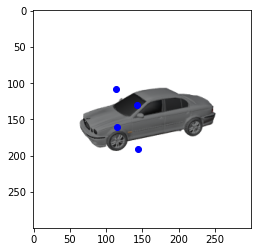

In [66]:
plt.figure()
plt.imshow(im)
# plt.scatter(x = loc_2d[3,0], y = loc_2d[3,1], c = 'r')
# plt.scatter(x = loc_2d[2,0], y = loc_2d[2,1], c = 'g')
# plt.scatter(x = loc_2d[6,0], y = loc_2d[6,1], c = 'b')
# plt.scatter(x = loc_2d[7,0], y = loc_2d[7,1], c = 'k')

interp = 10
# plt.scatter(x = loc_2d[4:,0], y = loc_2d[4:,1], c = 'g')
plt.scatter(x = loc_mid_2d[interp,:,0], y = loc_mid_2d[interp,:,1], c = 'b')

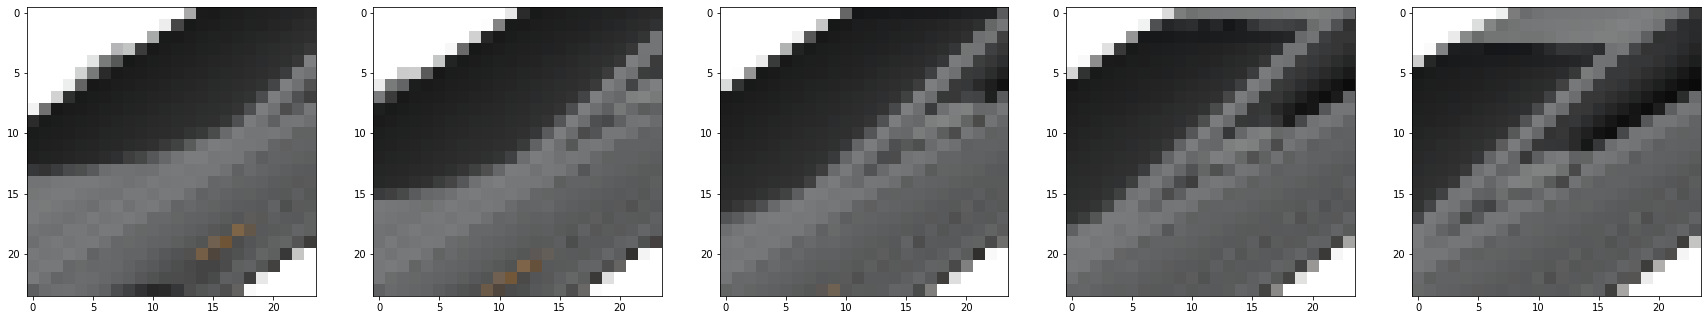

In [65]:
height, width = 24, 24

fig, axs = plt.subplots(1,5, figsize=(30,10))

interp = 10
for i in range(5):
    src = loc_mid_2d[i + interp,:,:2]
    dst = np.array([[0,height],[width,height],[width,0],[0,0]])
    h, mask = cv2.findHomography(src, dst)
    axs[i].imshow(cv2.warpPerspective(im, h, (width,height)))   

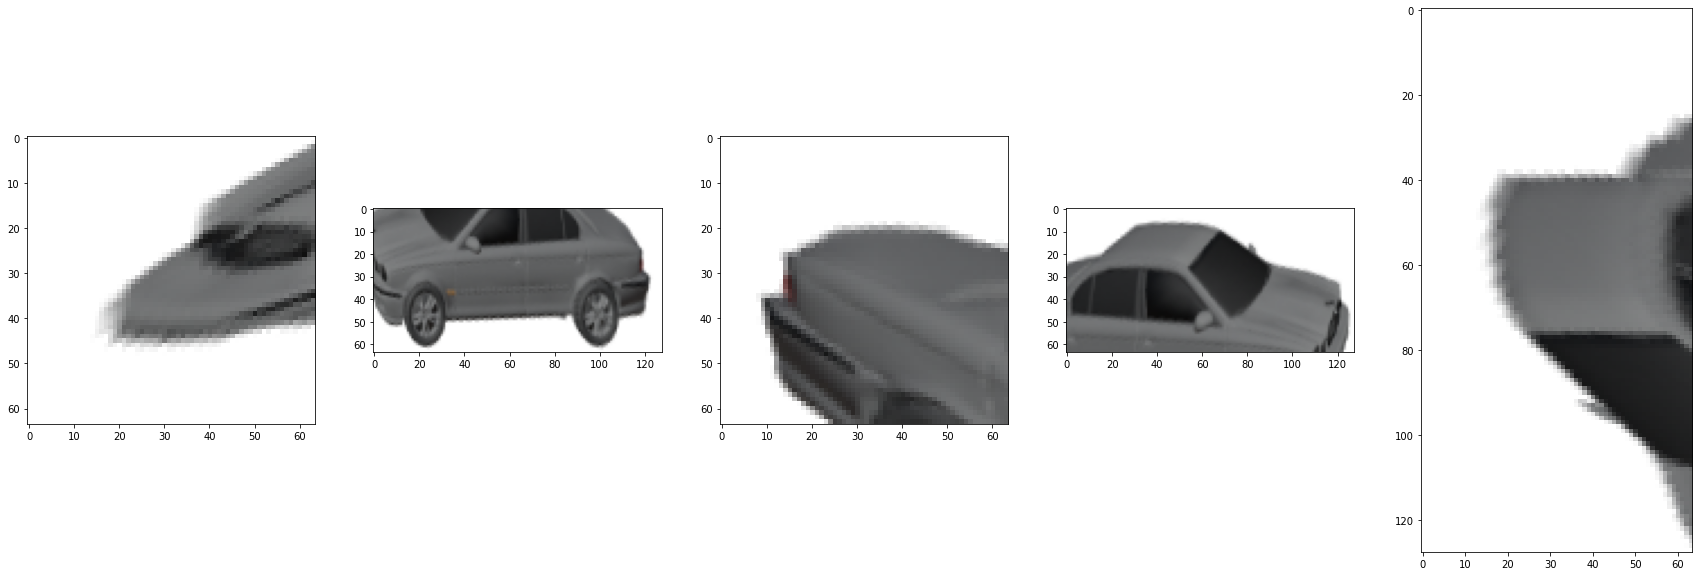

In [64]:
height, width, depth = 64, 64, 128

fig, axs = plt.subplots(1,5, figsize=(30,10))

# front
src = np.array([loc_2d[0,:2],loc_2d[1,:2],loc_2d[2,:2],loc_2d[3,:2]]).copy()
dst = np.array([[0,height],[width,height],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[0].imshow(cv2.warpPerspective(im, h, (width,height)))


src = np.array([loc_2d[1,:2],loc_2d[5,:2],loc_2d[6,:2],loc_2d[2,:2]]).copy()
dst = np.array([[0,height],[depth,height],[depth,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[1].imshow(cv2.warpPerspective(im, h, (depth,height)))


src = np.array([loc_2d[5,:2],loc_2d[4,:2],loc_2d[7,:2],loc_2d[6,:2]]).copy()
dst = np.array([[0,height],[width,height],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[2].imshow(cv2.warpPerspective(im, h, (width,height)))


src = np.array([loc_2d[4,:2],loc_2d[0,:2],loc_2d[3,:2],loc_2d[7,:2]]).copy()
dst = np.array([[0,height],[depth,height],[depth,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[3].imshow(cv2.warpPerspective(im, h, (depth,height)))


src = np.array([loc_2d[3,:2],loc_2d[2,:2],loc_2d[6,:2],loc_2d[7,:2]]).copy()
dst = np.array([[0,depth],[width,depth],[width,0],[0,0]])
h, mask = cv2.findHomography(src, dst)
axs[4].imshow(cv2.warpPerspective(im, h, (width,depth)))